<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1_Experiments_5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [6]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [7]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [8]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [9]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [13]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [15]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

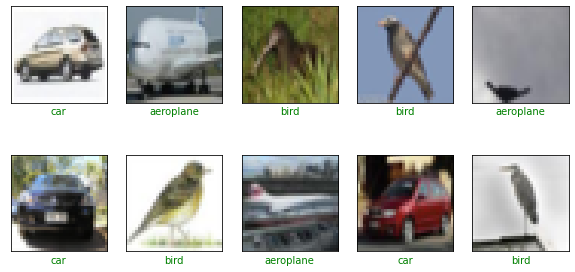

In [16]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [17]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [18]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [19]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [20]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 5: Experiment 4 with regularization 
https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

In [21]:
from time import perf_counter 
from keras import regularizers
from keras.layers.core import Dropout

#### Model 5.4 
Same as Model 4 with regularization

In [25]:
## Build CNN

model_5_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:], kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 512)       590336    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 512)         0

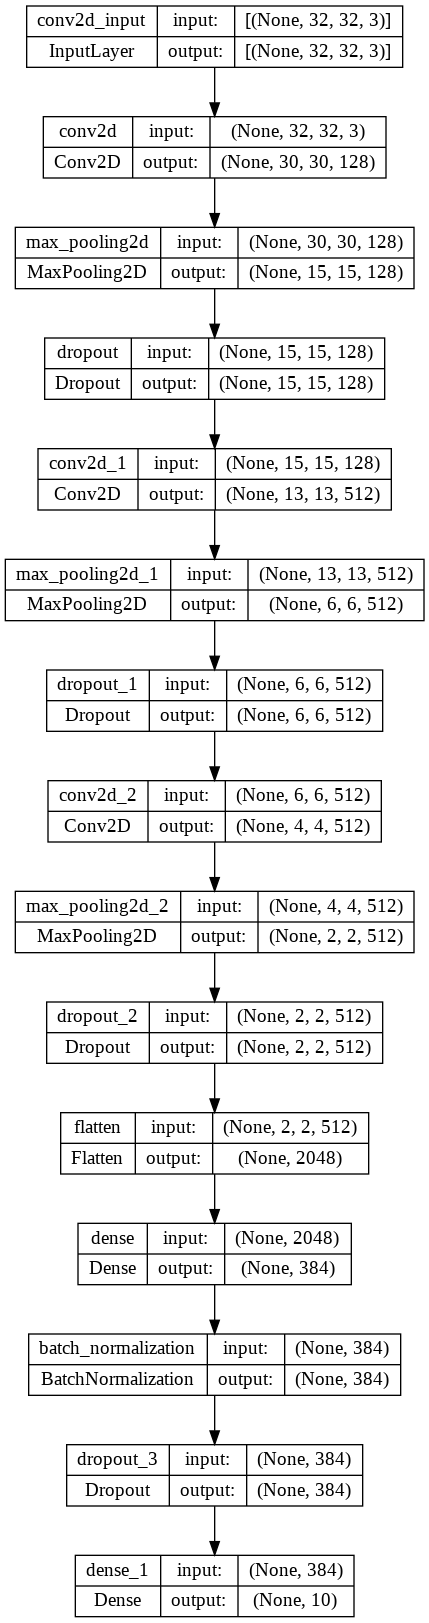

In [26]:
keras.utils.plot_model(model_5_4, "CIFAR10.png", show_shapes=True) 

In [27]:
## Compile
model_5_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [28]:
## Train
time = perf_counter()

history_5_4 = model_5_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 23s 20ms/step - loss: 1.8536 - accuracy: 0.3852 - val_loss: 1.6735 - val_accuracy: 0.4644
Epoch 2/200
704/704 [==============================] - 13s 19ms/step - loss: 1.5865 - accuracy: 0.5104 - val_loss: 1.4923 - val_accuracy: 0.5366
Epoch 3/200
704/704 [==============================] - 13s 19ms/step - loss: 1.5100 - accuracy: 0.5546 - val_loss: 1.5203 - val_accuracy: 0.5438
Epoch 4/200
704/704 [==============================] - 13s 19ms/step - loss: 1.4473 - accuracy: 0.5930 - val_loss: 1.7209 - val_accuracy: 0.5020
Epoch 5/200
704/704 [==============================] - 13s 19ms/step - loss: 1.4120 - accuracy: 0.6126 - val_loss: 1.3082 - val_accuracy: 0.6482
Epoch 6/200
704/704 [==============================] - 13s 19ms/step - loss: 1.3751 - accuracy: 0.6256 - val_loss: 1.3911 - val_accuracy: 0.6270
Epoch 7/200
704/704 [==============================] - 14s 19ms/step - loss: 1.3500 - accuracy: 0.6421 - val_loss: 1.3643 - val_ac

In [29]:
time_5_4 = perf_counter() - time
print(time_5_4)

269.529175194


In [30]:
## Evalute

model_5_4 = tf.keras.models.load_model("CNN_model_5_4.h5")
print(f"Test acc: {model_5_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.1409 - accuracy: 0.7282
Test acc: 0.728


#### Model 5.4.1
Same as Model 5.4 + updated dropout (0.1)

In [31]:
## Build CNN

model_5_41 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:], kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_41.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 6, 6, 256)        

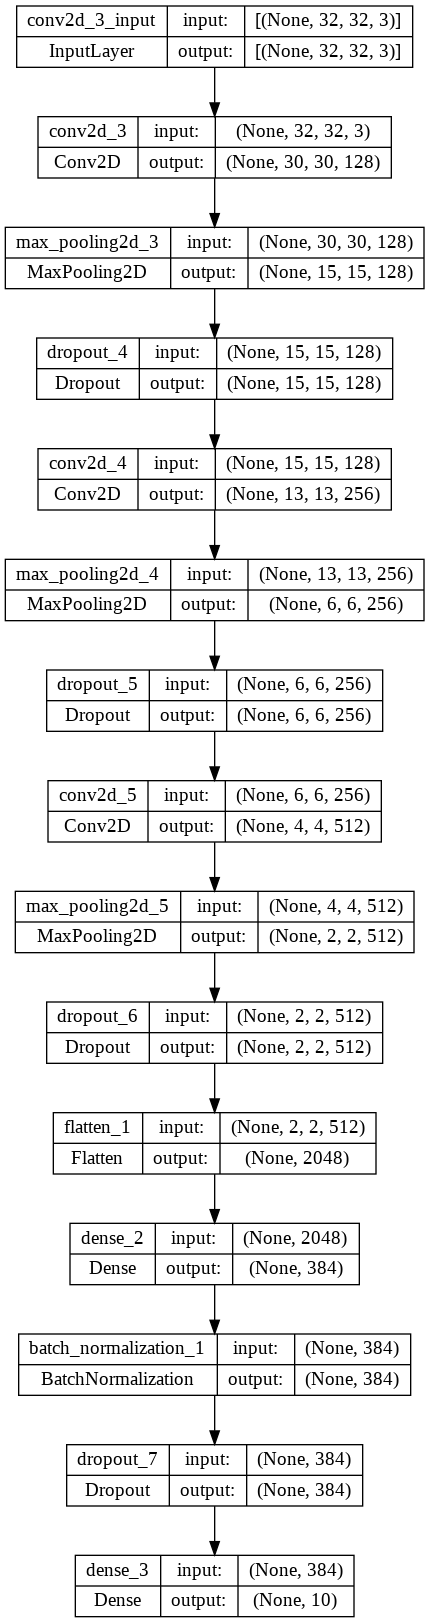

In [32]:
keras.utils.plot_model(model_5_41, "CIFAR10.png", show_shapes=True) 

In [33]:
## Compile
model_5_41.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [34]:
## Train
time = perf_counter()

history_5_41 = model_5_41.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_41.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.5656 - accuracy: 0.4559 - val_loss: 1.3411 - val_accuracy: 0.5370
Epoch 2/200
704/704 [==============================] - 9s 13ms/step - loss: 1.1633 - accuracy: 0.6138 - val_loss: 1.3926 - val_accuracy: 0.5564
Epoch 3/200
704/704 [==============================] - 9s 13ms/step - loss: 0.9896 - accuracy: 0.6811 - val_loss: 1.0340 - val_accuracy: 0.6638
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 0.8841 - accuracy: 0.7195 - val_loss: 0.9704 - val_accuracy: 0.6966
Epoch 5/200
704/704 [==============================] - 9s 13ms/step - loss: 0.8006 - accuracy: 0.7509 - val_loss: 0.8947 - val_accuracy: 0.7124
Epoch 6/200
704/704 [==============================] - 9s 13ms/step - loss: 0.7275 - accuracy: 0.7769 - val_loss: 0.9182 - val_accuracy: 0.7112
Epoch 7/200
704/704 [==============================] - 9s 13ms/step - loss: 0.6686 - accuracy: 0.7973 - val_loss: 0.8099 - val_accuracy

In [35]:
time_5_41 = perf_counter() - time
print(time_5_41)

165.51262694700006


In [36]:
## Evalute

model_5_41 = tf.keras.models.load_model("CNN_model_5_41.h5")
print(f"Test acc: {model_5_41.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.8287 - accuracy: 0.7651
Test acc: 0.765


#### Model 5.4.2 - BEST MODEL 4
Same as Model 5.4.2 + L2 kernel regularizer changed (0.01)

In [50]:
## Build CNN

model_5_42 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:], kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.sigmoid)       
])
model_5_42.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 6, 6, 256)        

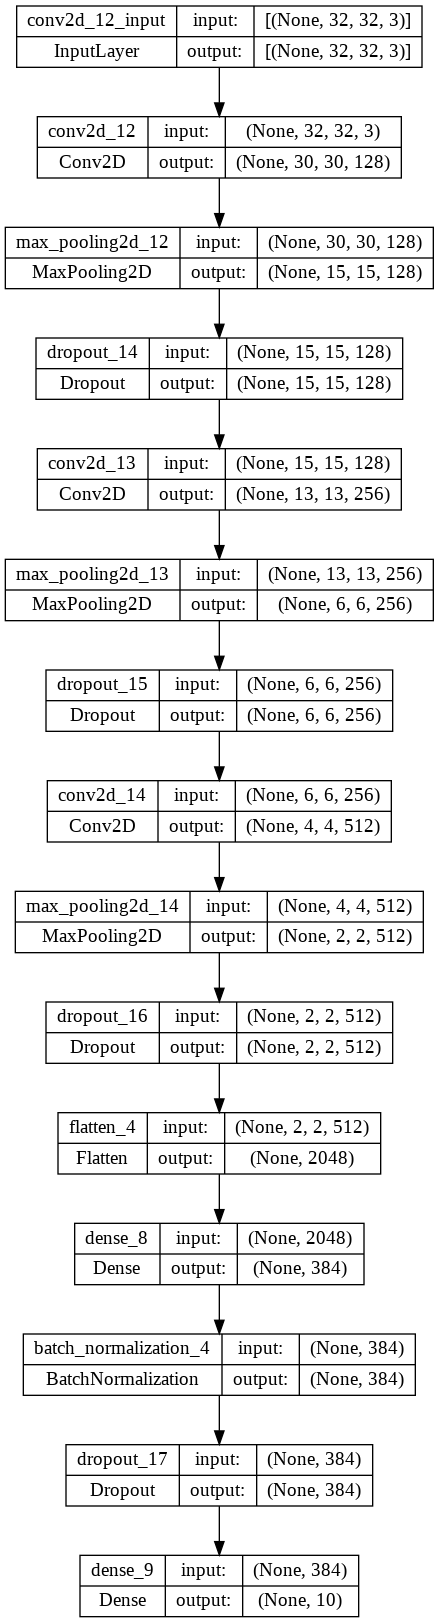

In [51]:
keras.utils.plot_model(model_5_42, "CIFAR10.png", show_shapes=True) 

In [52]:
## Compile
model_5_42.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [53]:
## Train
time = perf_counter()

history_5_42 = model_5_42.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_42.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 2.5019 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/200
704/704 [==============================] - 9s 13ms/step - loss: 2.3029 - accuracy: 0.0996 - val_loss: 2.3030 - val_accuracy: 0.1046
Epoch 3/200
704/704 [==============================] - 9s 13ms/step - loss: 2.3029 - accuracy: 0.0984 - val_loss: 2.3031 - val_accuracy: 0.1008
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 2.3029 - accuracy: 0.1004 - val_loss: 2.3029 - val_accuracy: 0.0972
Epoch 5/200
704/704 [==============================] - 9s 13ms/step - loss: 2.3028 - accuracy: 0.0995 - val_loss: 2.3028 - val_accuracy: 0.1008


In [54]:
time_5_42 = perf_counter() - time
print(time_5_42)

47.438986672000055


In [55]:
## Evalute

model_5_42 = tf.keras.models.load_model("CNN_model_5_42.h5")
print(f"Test acc: {model_5_42.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 2.3036 - accuracy: 0.1000
Test acc: 0.100


#### Model 5.4.3
Same as Model 5.4.2 + updated output activation = sigmoid

In [44]:
## Build CNN

model_5_43 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.sigmoid)       
])
model_5_43.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 6, 6, 256)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 512)        

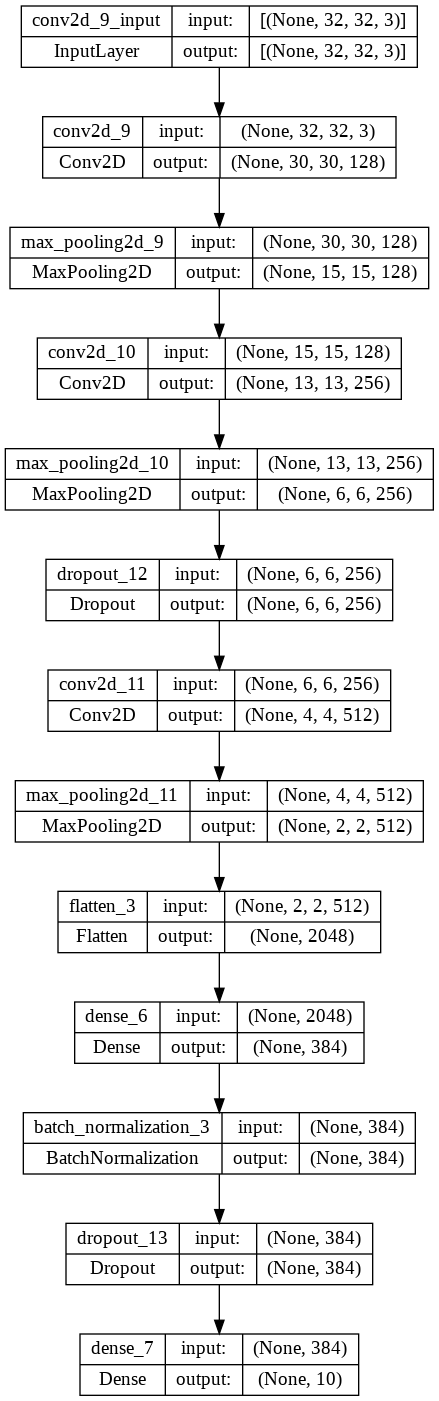

In [45]:
keras.utils.plot_model(model_5_43, "CIFAR10.png", show_shapes=True) 

In [46]:
## Compile
model_5_43.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [47]:
## Train
time = perf_counter()

history_5_43 = model_5_43.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_43.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.7700 - accuracy: 0.3894 - val_loss: 1.5922 - val_accuracy: 0.4710
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.3851 - accuracy: 0.5655 - val_loss: 1.5619 - val_accuracy: 0.5294
Epoch 3/200
704/704 [==============================] - 9s 13ms/step - loss: 1.2660 - accuracy: 0.6259 - val_loss: 1.5647 - val_accuracy: 0.5244
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 1.1824 - accuracy: 0.6631 - val_loss: 1.2944 - val_accuracy: 0.6276
Epoch 5/200
704/704 [==============================] - 9s 13ms/step - loss: 1.1257 - accuracy: 0.6877 - val_loss: 1.3308 - val_accuracy: 0.6224
Epoch 6/200
704/704 [==============================] - 9s 13ms/step - loss: 1.0821 - accuracy: 0.7083 - val_loss: 1.3921 - val_accuracy: 0.6076
Epoch 7/200
704/704 [==============================] - 9s 13ms/step - loss: 1.0501 - accuracy: 0.7229 - val_loss: 1.0798 - val_accuracy

In [48]:
time_5_43 = perf_counter() - time
print(time_5_43)

91.14839751199997


In [49]:
## Evalute

model_5_43 = tf.keras.models.load_model("CNN_model_5_43.h5")
print(f"Test acc: {model_5_43.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 1.0696 - accuracy: 0.7178
Test acc: 0.718
